# Preliminary analysis of CDC pilot project

In [372]:
import pandas as pd
from ete3 import NCBITaxa
import os
import seaborn
import matplotlib.pyplot as plt
import math
import re
import numpy as np

Download NCBI taxonomy database: 

In [373]:
ncbi = NCBITaxa()
#ncbi.update_taxonomy_database()

Download table from IDseq containing number of reads mapping to each species.

In [374]:
report_dir = "../../data/MOS002_reports"
sample_table_csv = "../../data/MOS002_sample-table.csv"

In [4]:
sample_table = pd.read_csv(sample_table_csv)

## Reports

In [318]:
report_csv = report_dir+"/"+sample_table.sample_name+"_report.csv"
reports = pd.concat([pd.read_csv(x).assign(sample_name=os.path.basename(x).replace("_report.csv", "")) for x in report_csv])
reports = pd.merge(reports, sample_table[['sample_name', 'total_reads', 'nonhost_reads', 'nonhost_reads_percent', 'ercc_reads', 'tissue_type', 'location', 'notes', 'sample_diagnosis']], how='left', on='sample_name')
total_reads = reports[reports.tax_level==2].groupby('sample_name')['NR_r'].sum()

/Users/lucy.li/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [319]:
bloodmeal_top_perc_id = reports[(reports.category_name=="Eukaryota") & (reports.tax_level==2)].groupby(['sample_name']).head(5).groupby(['sample_name']).agg({'NR_percentidentity':'max'}).rename({'NR_percentidentity':'max_NR_percentidentity'}, axis='columns')
bloodmeal_df = pd.merge(reports, bloodmeal_top_perc_id, how='left', on=['sample_name'])
bloodmeal_df = bloodmeal_df[bloodmeal_df['NR_percentidentity']==bloodmeal_df['max_NR_percentidentity']].groupby(['sample_name']).head(1)[['sample_name', 'name', 'common_name', 'tax_id', 'location', 'notes', 'sample_diagnosis']]
bloodmeal_df['species'] = bloodmeal_df.notes.str.split('\n- genus_species: ').str[1].str.split('\n').str[0]
bloodmeal_df['bloodfed'] = bloodmeal_df.notes.str.split('\n- Blood fed: ').str[1].str.split('\n').str[0].replace({'Y': True, 'N': False})
bloodmeal_df = bloodmeal_df.drop('notes', axis=1)
bloodmeal_df.head()


,sample_name,name,common_name,tax_id,location,sample_diagnosis,species,bloodfed
2,MOS002-01a-hom-R1,Anser,geese,8842,lab,flavivirus spike-in,Culex quinquefasciatus,True
898,MOS002-02a-hom-R1,Anser,geese,8842,lab,flavivirus spike-in,Culex quinquefasciatus,True
1553,MOS002-03a-hom-R1,Anser,geese,8842,lab,flavivirus spike-in,Culex quinquefasciatus,True
2190,MOS002-04a-hom-R1,Anser,geese,8842,lab,flavivirus spike-in,Culex quinquefasciatus,True
3105,MOS002-05a-hom-R1,Anser,geese,8842,lab,flavivirus spike-in,Culex quinquefasciatus,True


In [320]:
bloodmeal_df.to_csv("../../data/MOS002_sample_table_bloodmeal_calls.csv")

In [325]:
reports_viruses = reports[((reports.category_name=="Viruses") | (reports.name.str.contains("virus"))) & (reports.tax_level==2)]

In [328]:
NR_r_family = reports_viruses.groupby(['sample_name', 'family_taxid'])['NR_r'].sum().to_frame()
NR_r_family = NR_r_family.reset_index(level=0).reset_index(level=0)
family_dict = ncbi.get_taxid_translator(NR_r_family.family_taxid.tolist())
NR_r_family['family_name'] = NR_r_family.family_taxid.apply(lambda x: family_dict[x] if x>0 else 'unassigned Mononegavirales')
for x in sample_table.sample_name:
    if (not NR_r_family.sample_name.str.contains(x).any()):
        dict_to_add = {'family_taxid': "none found", 'sample_name': x, 'NR_r': 0.0, 'family_name': "none found"}
        NR_r_family = NR_r_family.append(dict_to_add, ignore_index=True)
NR_r_family.sort_values(by='sample_name', axis=0, inplace=True)
NR_r_family = NR_r_family[['sample_name', 'family_name', 'NR_r']].groupby(['sample_name', 'family_name'])['NR_r'].sum().to_frame().reset_index(level=0).reset_index(level=0)

In [329]:
NR_r_family.head()

,family_name,sample_name,NR_r
0,Herpesviridae,MOS002-01a-hom-R1,3.0
1,Rhabdoviridae,MOS002-01a-hom-R1,2.0
2,none found,MOS002-02a-hom-R1,0.0
3,none found,MOS002-03a-hom-R1,0.0
4,Herpesviridae,MOS002-04a-hom-R1,1.0


## Plotting heatmap of viruses

In [333]:
def plot_heatmap (df, title='', vmin=math.log10(0.00000001), vmax=math.log10(NR_r_family.NR_r.max())):
    df = pd.pivot_table(df, values='NR_r', index=['sample_name'], columns=["family_name"]).fillna(0)
    df = df.applymap(lambda x: math.log10(x+0.00000001))
    if ('none found' in df.columns):
        df = df.drop('none found', axis=1)
    seaborn.set(style="whitegrid", font_scale=2)
    ax = seaborn.heatmap(data=df, vmin=vmin, vmax=vmax, cmap="RdPu", xticklabels=True, yticklabels=True)
    ax.set_title(title)


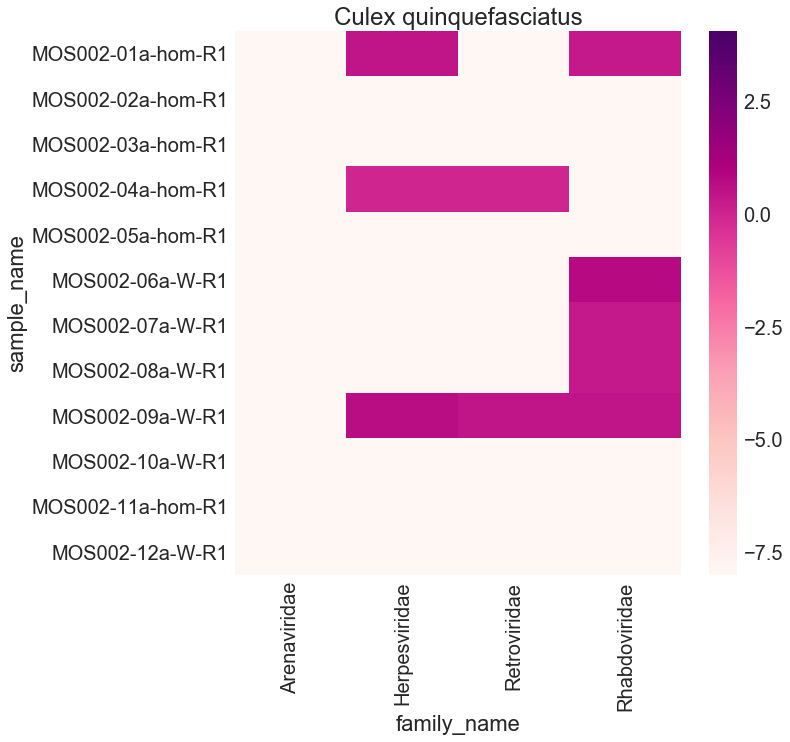

In [334]:
culex_quing_virus_df = NR_r_family[:NR_r_family.loc[NR_r_family.sample_name.str.contains('13a')].index[0]]
plot_heatmap (culex_quing_virus_df, title="Culex quinquefasciatus")

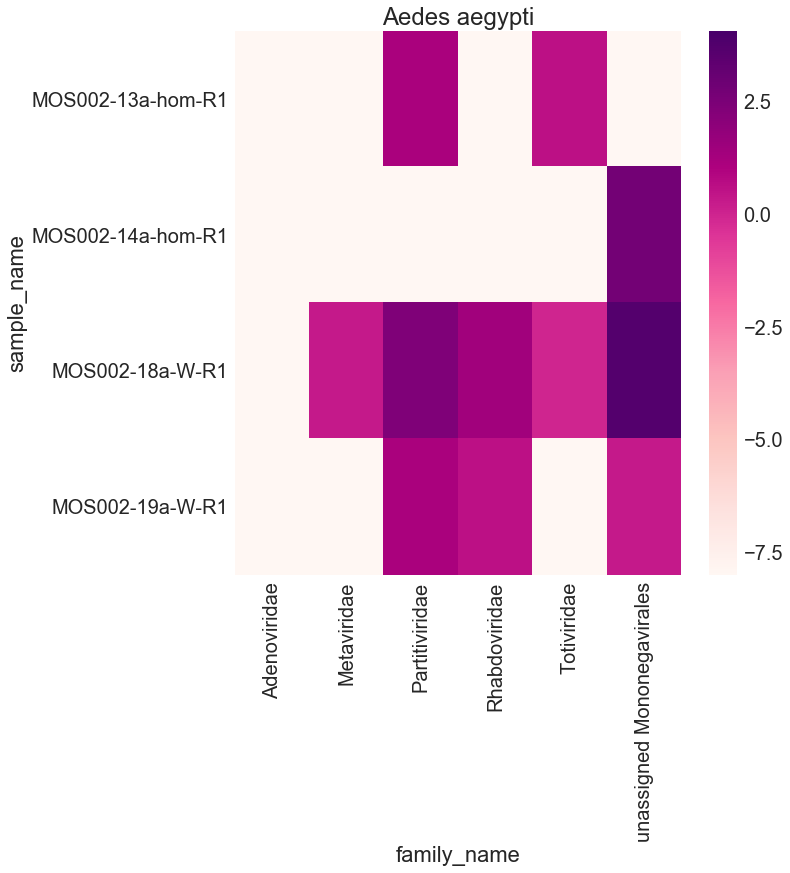

In [335]:
aedes_aegypti_virus_df = NR_r_family.loc[NR_r_family.sample_name.str.contains('1[3-48-9]a', regex=True)]
plot_heatmap (aedes_aegypti_virus_df, title="Aedes aegypti")

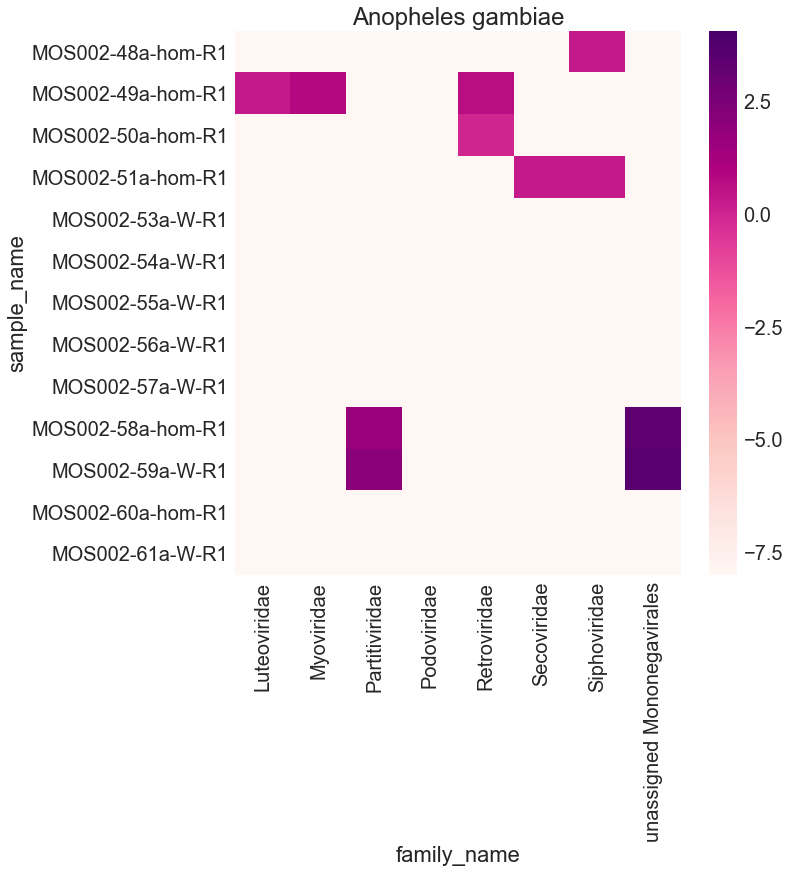

In [336]:
anopheles_gambiae_virus_df = NR_r_family.loc[NR_r_family.sample_name.str.contains('4[8-9]a|5[0-1|3-9]a|6[0|1]a', regex=True)]
anopheles_gambiae_virus_df
plot_heatmap (anopheles_gambiae_virus_df, title="Anopheles gambiae")


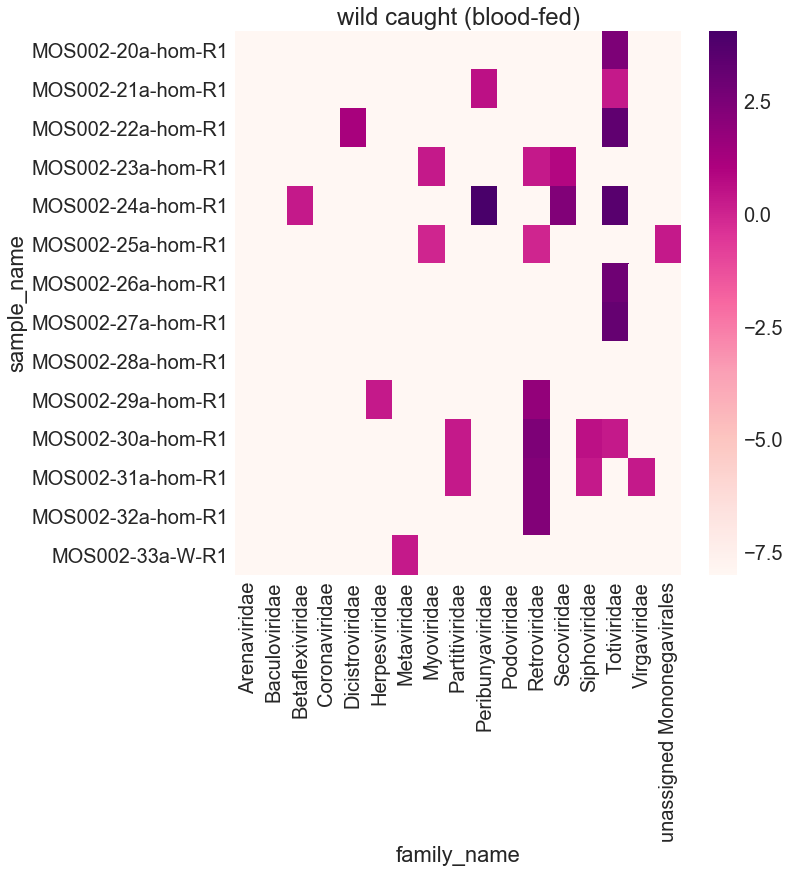

In [337]:
wild_bloodfed_df = NR_r_family.loc[NR_r_family.sample_name.str.contains('2[0-9]a|3[0-3]a', regex=True)]
plot_heatmap (wild_bloodfed_df, title="wild caught (blood-fed)")

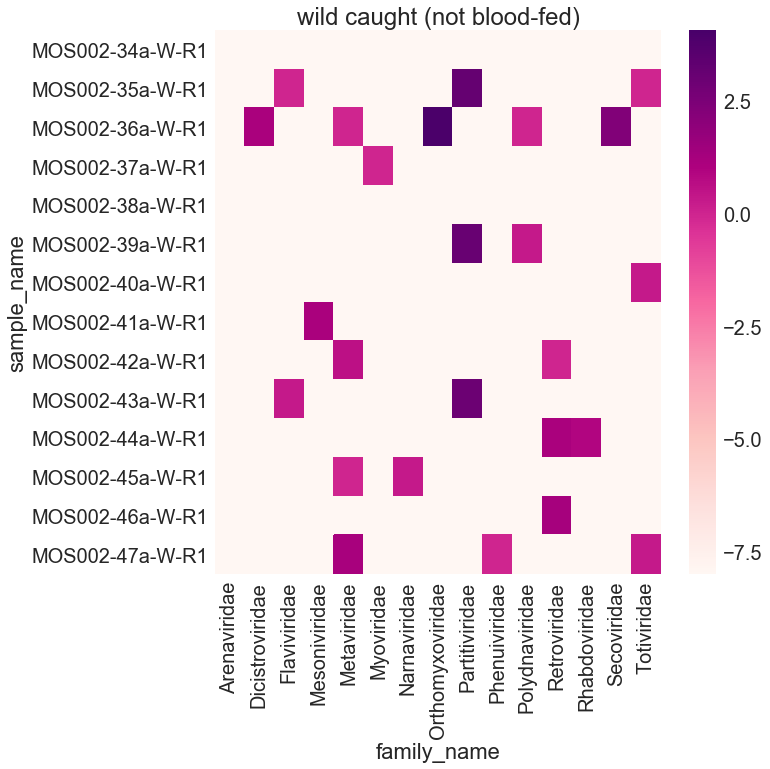

In [338]:
wild_nonbloodfed_df = NR_r_family.loc[NR_r_family.sample_name.str.contains('3[4-9]a|4[0-7]a', regex=True)]
plot_heatmap (wild_nonbloodfed_df, title="wild caught (not blood-fed)")

## Comparing CMS samples with CDC pilot data

In [339]:
virus_r = reports_viruses.groupby('sample_name').NR_r.sum()

In [340]:
cms_reports_dir = "../../data/CMS_reports"
cms_samples_csv = "../../data/project-mosquito_sample-table.csv"
cms_reports_csv = os.listdir(cms_reports_dir)


In [341]:
cms_reports = pd.concat([pd.read_csv(cms_reports_dir+'/'+x).assign(sample_name=x.replace('.csv', '')) for x in cms_reports_csv])


/Users/lucy.li/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [342]:
cms_virus_criteria = [(cms_reports.category_name=="Viruses"),
                      (cms_reports.name.str.contains("virus")),
                     (cms_reports.tax_level==2)]
cms_virus_r = cms_reports[(cms_virus_criteria[0] | cms_virus_criteria[1]) & cms_virus_criteria[2]].groupby('sample_name').NR_r.sum()


In [343]:
cms_samples = pd.read_csv(cms_samples_csv)
cms_samples = cms_samples[cms_samples.sample_name.str.startswith('CMS')]

In [344]:
sample_table[['sample_name', 'total_reads', 'nonhost_reads_percent']].head()

,sample_name,total_reads,nonhost_reads_percent
0,MOS002-01a-hom-R1,26765390,0.219
1,MOS002-02a-hom-R1,30669608,0.105
2,MOS002-03a-hom-R1,33723700,0.112
3,MOS002-04a-hom-R1,47251396,0.106
4,MOS002-05a-hom-R1,26482816,0.211


In [345]:
cms_samples[['sample_name', 'total_reads', 'nonhost_reads_percent']].head()

,sample_name,total_reads,nonhost_reads_percent
0,CMS_001_06_S5_L001,31771554,0.387
1,CMS_001_17_S6_L001,35183096,0.331
2,CMS_001_32_S7_L001,36829212,0.280
3,CMS_001_RNA_A_S1,26717044,3.528
4,CMS_002_10a_Rb_S119_L004,89358216,0.072


In [346]:
sample_table

,sample_name,uploader,upload_date,runtime_seconds,overall_job_status,num_input_files,total_reads,nonhost_reads,nonhost_reads_percent,ercc_reads,subsampled_fraction,quality_control,compression_ratio,tissue_type,nucleotide_type,location,host_genome,notes,sample_diagnosis
0,MOS002-01a-hom-R1,Amy Kistler,10/5/18 18:20,3610,COMPLETE,2,26765390,58592,0.219,4862,1.000000,63.107,1.66,Insect abdomen,RNA,lab,Mosquito,- id_method : freeze\n- genus_species: Culex q...,flavivirus spike-in
1,MOS002-02a-hom-R1,Amy Kistler,10/6/18 7:41,2828,COMPLETE,2,30669608,32320,0.105,6994,1.000000,62.672,1.51,Insect abdomen,RNA,lab,Mosquito,- id_method : freeze\n- genus_species: Culex q...,flavivirus spike-in
2,MOS002-03a-hom-R1,Amy Kistler,10/6/18 7:44,3008,COMPLETE,2,33723700,37872,0.112,7900,1.000000,58.779,1.44,Insect abdomen,RNA,lab,Mosquito,- id_method : freeze\n- genus_species: Culex q...,flavivirus spike-in
3,MOS002-04a-hom-R1,Amy Kistler,10/6/18 7:46,3383,COMPLETE,2,47251396,50322,0.106,10884,1.000000,63.561,1.69,Insect abdomen,RNA,lab,Mosquito,- id_method : freeze\n- genus_species: Culex q...,flavivirus spike-in
4,MOS002-05a-hom-R1,Amy Kistler,10/6/18 7:48,2824,COMPLETE,2,26482816,55990,0.211,8280,1.000000,69.914,1.50,Insect abdomen,RNA,lab,Mosquito,- id_method : freeze\n- genus_species: Culex q...,flavivirus spike-in
5,MOS002-06a-W-R1,Amy Kistler,10/7/18 14:18,4123,COMPLETE,2,44870242,212768,0.474,8140,1.000000,75.459,1.84,Whole insect,RNA,lab,Mosquito,- id_method : freeze\n- genus_species: Culex q...,NaN
6,MOS002-07a-W-R1,Amy Kistler,10/7/18 14:22,4183,COMPLETE,2,41267624,182510,0.442,7260,1.000000,67.823,1.86,Whole insect,RNA,lab,Mosquito,- id_method : freeze\n- genus_species: Culex q...,NaN
7,MOS002-08a-W-R1,Amy Kistler,10/7/18 14:23,3589,COMPLETE,2,38844270,168044,0.433,6590,1.000000,71.497,1.71,Whole insect,RNA,lab,Mosquito,- id_method : freeze\n- genus_species: Culex q...,NaN
8,MOS002-09a-W-R1,Amy Kistler,10/7/18 14:24,5831,COMPLETE,2,59641536,325054,0.545,14146,1.000000,76.373,1.97,Whole insect,RNA,lab,Mosquito,-collaborator id: Pilot18-009 \n- id_method : ...,NaN
9,MOS002-10a-W-R1,Amy Kistler,10/6/18 11:51,5035,COMPLETE,2,56352198,185002,0.328,9010,1.000000,76.020,1.80,Whole insect,RNA,lab,Mosquito,- id_method : freeze\n- genus_species: Culex q...,NaN


In [367]:
sample_table_plotting = sample_table[['sample_name', 'total_reads', 'nonhost_reads', 'nonhost_reads_percent', 'tissue_type', 'location']]
sample_table_plotting = sample_table_plotting.assign(study='CDC pilot')
sample_table_plotting = sample_table_plotting.assign(prep=sample_table_plotting.sample_name.str.contains('hom'))
sample_table_plotting = sample_table_plotting.replace(to_replace={True:'homogenate', False:'whole mosquito'})
sample_table_plotting.loc[sample_table_plotting.sample_name.str.contains('ater'), 'prep'] = 'water'
sample_table_plotting = pd.merge(sample_table_plotting, virus_r.to_frame(), how='left',
                                 left_on='sample_name', right_index=True).rename(columns={'NR_r':'viral_reads'})
sample_table_plotting.head()



,sample_name,total_reads,nonhost_reads,nonhost_reads_percent,tissue_type,location,study,prep,viral_reads
0,MOS002-01a-hom-R1,26765390,58592,0.219,Insect abdomen,lab,CDC pilot,homogenate,5.0
1,MOS002-02a-hom-R1,30669608,32320,0.105,Insect abdomen,lab,CDC pilot,homogenate,NaN
2,MOS002-03a-hom-R1,33723700,37872,0.112,Insect abdomen,lab,CDC pilot,homogenate,NaN
3,MOS002-04a-hom-R1,47251396,50322,0.106,Insect abdomen,lab,CDC pilot,homogenate,2.0
4,MOS002-05a-hom-R1,26482816,55990,0.211,Insect abdomen,lab,CDC pilot,homogenate,NaN


In [363]:
cms_table_plotting = cms_samples[['sample_name', 'total_reads', 'nonhost_reads', 'nonhost_reads_percent', 'tissue_type']]
cms_table_plotting = cms_table_plotting.assign(location='wild-caught')
cms_table_plotting = cms_table_plotting.assign(study=cms_table_plotting.sample_name.str.contains('CMS_002')).assign(prep='whole mosquito')
cms_table_plotting.study = cms_table_plotting.study.replace({True:"CMS002", False:"CMS001"})
cms_table_plotting.loc[cms_table_plotting.sample_name.str.contains('ater'), 'prep'] = 'water'
cms_table_plotting.loc[cms_table_plotting.sample_name.str.contains('ater'), 'location'] = 'NaN'
cms_table_plotting['sample_name_lower'] = cms_table_plotting['sample_name'].str.lower()
cms_table_plotting = pd.merge(cms_table_plotting, cms_virus_r.to_frame(), how='left',
                              left_on='sample_name_lower', right_index=True)
cms_table_plotting = cms_table_plotting.rename(columns={'NR_r':'viral_reads'}).drop('sample_name_lower', axis=1)
cms_table_plotting.head(10)

,sample_name,total_reads,nonhost_reads,nonhost_reads_percent,tissue_type,location,study,prep,viral_reads
0,CMS_001_06_S5_L001,31771554,122820.0,0.387,NaN,wild-caught,CMS001,whole mosquito,30.0
1,CMS_001_17_S6_L001,35183096,116474.0,0.331,NaN,wild-caught,CMS001,whole mosquito,491.0
2,CMS_001_32_S7_L001,36829212,103214.0,0.280,NaN,wild-caught,CMS001,whole mosquito,13410.0
3,CMS_001_RNA_A_S1,26717044,942568.0,3.528,Insect engorged abdomen,wild-caught,CMS001,whole mosquito,693.0
4,CMS_002_10a_Rb_S119_L004,89358216,63970.0,0.072,whole mosquito,wild-caught,CMS002,whole mosquito,5482.0
5,CMS_002_13a_Rb_S120_L004,76144326,125128.0,0.164,whole mosquito,wild-caught,CMS002,whole mosquito,12198.0
6,CMS_002_16a_Rb_S121_L004,81220802,5696.0,0.007,whole mosquito,wild-caught,CMS002,whole mosquito,NaN
7,CMS_002_17a_Rb_S122_L004,75330508,177954.0,0.236,whole mosquito,wild-caught,CMS002,whole mosquito,1619.0
8,CMS_002_17b_Rb_S123_L004,77087486,198902.0,0.258,whole mosquito,wild-caught,CMS002,whole mosquito,2043.0
9,CMS_002_17c_Rb_S124_L004,66242378,184544.0,0.279,whole mosquito,wild-caught,CMS002,whole mosquito,2696.0


In [365]:
combined_samples_table = pd.concat([sample_table_plotting, cms_table_plotting], axis=0)
combined_samples_table = combined_samples_table.assign(log10_viral_reads = combined_samples_table.viral_reads.apply(lambda x: np.log10(x+1)))
combined_samples_table = combined_samples_table.assign(whole_insect = combined_samples_table.tissue_type.str.contains("hole", na=True))

/Users/lucy.li/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/lucy.li/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


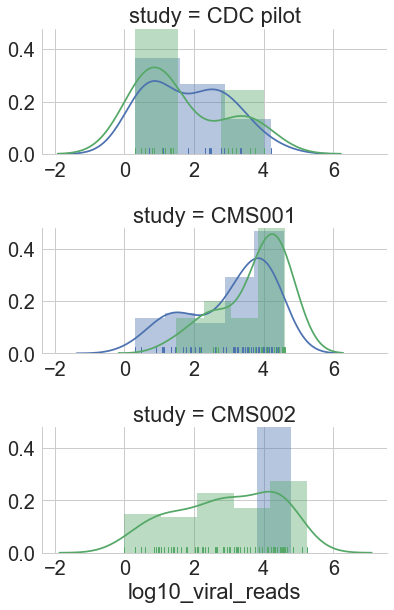

In [371]:
viral_reads_plot = seaborn.FacetGrid(data=combined_samples_table[combined_samples_table.prep!='water'],
                                    hue="whole_insect", row="study", aspect=2)
viral_reads_plot = (viral_reads_plot.map(seaborn.distplot, "log10_viral_reads", hist=True, rug=True))
viral_reads_plot

In [368]:
combined_samples_table

,sample_name,total_reads,nonhost_reads,nonhost_reads_percent,tissue_type,location,study,prep,viral_reads,log10_viral_reads,whole_insect
0,MOS002-01a-hom-R1,26765390,58592.0,0.219,Insect abdomen,lab,CDC pilot,homogenate,5.0,0.778151,False
1,MOS002-02a-hom-R1,30669608,32320.0,0.105,Insect abdomen,lab,CDC pilot,homogenate,NaN,NaN,False
2,MOS002-03a-hom-R1,33723700,37872.0,0.112,Insect abdomen,lab,CDC pilot,homogenate,NaN,NaN,False
3,MOS002-04a-hom-R1,47251396,50322.0,0.106,Insect abdomen,lab,CDC pilot,homogenate,2.0,0.477121,False
4,MOS002-05a-hom-R1,26482816,55990.0,0.211,Insect abdomen,lab,CDC pilot,homogenate,NaN,NaN,False
5,MOS002-06a-W-R1,44870242,212768.0,0.474,Whole insect,lab,CDC pilot,whole mosquito,6.0,0.845098,True
6,MOS002-07a-W-R1,41267624,182510.0,0.442,Whole insect,lab,CDC pilot,whole mosquito,2.0,0.477121,True
7,MOS002-08a-W-R1,38844270,168044.0,0.433,Whole insect,lab,CDC pilot,whole mosquito,2.0,0.477121,True
8,MOS002-09a-W-R1,59641536,325054.0,0.545,Whole insect,lab,CDC pilot,whole mosquito,11.0,1.079181,True
9,MOS002-10a-W-R1,56352198,185002.0,0.328,Whole insect,lab,CDC pilot,whole mosquito,NaN,NaN,True
